In [1]:
import pysam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

In [2]:
#Read chromosomes and extract the Chromosome ID, Chromosome Name and Size in Mb

filename= 'GCF_008822105.2_bTaeGut2.pat.W.v2_genomic.fna.gz'
chr_names = dict()
chr_size = dict()
with pysam.FastxFile(filename) as fh:
    for entry in fh:
        if 'unlocalized' in entry.comment:
            continue
        if 'chromosome' in entry.comment:
            chr_names[entry.name] = ''.join(('Chr_',entry.comment.split(',')[0].split('chromosome ')[1]))
            chr_size[chr_names[entry.name]] = len(entry.sequence)

A = pd.DataFrame.from_dict(chr_names, orient='index').reset_index().rename(columns={'index':'ID',0:'Chr'})
B = pd.DataFrame.from_dict(chr_size, orient='index').reset_index().rename(columns={0:'Size','index':'Chr'})
Zf_ChrTable = pd.merge(A,B, left_on='Chr', right_on='Chr')
Zf_ChrTable['Size_Mb'] = Zf_ChrTable.Size.apply(lambda x: np.round(x/1000000,2))

#Print chromosomes greater than 20Mb in size
Zf_ChrTable[Zf_ChrTable.Size_Mb>20]

ID     Chr       Size  Size_Mb
0   NC_044998.1   Chr_1  114375790   114.38
1   NC_044999.1  Chr_1A   70879221    70.88
2   NC_045000.1   Chr_2  151896526   151.90
3   NC_045001.1   Chr_3  111449612   111.45
4   NC_045002.1   Chr_4   71343966    71.34
6   NC_045004.1   Chr_5   61898265    61.90
7   NC_045005.1   Chr_6   34836644    34.84
8   NC_045006.1   Chr_7   38159610    38.16
9   NC_045007.1   Chr_8   30964699    30.96
10  NC_045008.1   Chr_9   25566760    25.57
11  NC_045009.1  Chr_10   20434694    20.43
12  NC_045010.1  Chr_11   21061567    21.06
13  NC_045011.1  Chr_12   20382777    20.38
29  NC_045027.1   Chr_Z   78982076    78.98
30  NC_045028.1   Chr_W   20846394    20.85

In [3]:
#Commands for finding Tandem repeats in all chromosomes.

Fasta_chromosomes = 'Zf_ALL_chrs.fa'
out_fasta =open(Fasta_chromosomes,'w')
with pysam.FastxFile(filename) as fh:
    for entry in fh:
        if entry.name in Zf_ChrTable.ID.to_list():
            out_fasta.write(''.join(('>',chr_names[entry.name],'\n',entry.sequence,'\n')))
out_fasta.close()
print ('trf ', Fasta_chromosomes, ' 2 5 7 80 10 50 2000 -l 6 -d -ngs -h > ', ''.join((Fasta_chromosomes,'.out')))


trf  Zf_ALL_chrs.fa  2 5 7 80 10 50 2000 -l 6 -d -ngs -h >  Zf_ALL_chrs.fa.out


In [4]:
#Commands for finding Tandem repeats in all chromosomes that are greater than 20 Mb in size.

Fasta_chromosomes = 'Zf_chrs.fa'
out_fasta =open(Fasta_chromosomes,'w')
with pysam.FastxFile(filename) as fh:
    for entry in fh:
        if entry.name in Zf_ChrTable[Zf_ChrTable.Size_Mb>20].ID.to_list():
            out_fasta.write(''.join(('>',chr_names[entry.name],'\n',entry.sequence,'\n')))
out_fasta.close()
print ('trf ', Fasta_chromosomes, ' 2 5 7 80 10 50 2000 -l 6 -d -ngs -h > ', ''.join((Fasta_chromosomes,'.out')))



trf  Zf_chrs.fa  2 5 7 80 10 50 2000 -l 6 -d -ngs -h >  Zf_chrs.fa.out


In [5]:
#Same for chromosome 'W'

with pysam.FastxFile(filename) as fh:
    for entry in fh:
        if entry.name in Zf_ChrTable[Zf_ChrTable.Size_Mb>20].ID.to_list():
            Fasta_chr = ''.join(('Chromosomes/Zf_',chr_names[entry.name],'.fa'))
            out_fasta =open(Fasta_chr,'w')
            out_fasta.write(''.join(('>',chr_names[entry.name],'\n',entry.sequence.upper(),'\n')))
            out_fasta.close()

In [6]:
print ('trf ', Fasta_chr, ' 2 5 7 80 10 50 2000 -l 6 -d -ngs -h > ', ''.join((Fasta_chr,'.out')))

trf  Chromosomes/Zf_Chr_W.fa  2 5 7 80 10 50 2000 -l 6 -d -ngs -h >  Chromosomes/Zf_Chr_W.fa.out


In [7]:
# Make tables of chromosome boundaries
Mb = 1000000
SubTelomere_length =  7*Mb
Telomere_boundaries = copy.copy(Zf_ChrTable[Zf_ChrTable.Size_Mb>20])
Telomere_boundaries['Start_p'] =  0
Telomere_boundaries['End_p'] = SubTelomere_length
Telomere_boundaries.loc[:,'Start_q'] =  Telomere_boundaries.Size -  SubTelomere_length
Telomere_boundaries.loc[:,'End_q'] =  Telomere_boundaries.Size


In [8]:
Telomere_boundaries[['Chr','Size']].to_csv('Zf_chr_sizes.fai',sep='\t',index=False)
Telomere_boundaries[['Chr','Size']]

Chr       Size
0    Chr_1  114375790
1   Chr_1A   70879221
2    Chr_2  151896526
3    Chr_3  111449612
4    Chr_4   71343966
6    Chr_5   61898265
7    Chr_6   34836644
8    Chr_7   38159610
9    Chr_8   30964699
10   Chr_9   25566760
11  Chr_10   20434694
12  Chr_11   21061567
13  Chr_12   20382777
29   Chr_Z   78982076
30   Chr_W   20846394

In [9]:
A  = Telomere_boundaries[['Chr','Start_p','End_p']].rename(columns={'Start_p':'Start','End_p':'End'})
B  = Telomere_boundaries[['Chr','Start_q','End_q']].rename(columns={'Start_q':'Start','End_q':'End'})
C = A.append(B).sort_values(['Chr','Start'])
C.to_csv('Telomere_positions.tab',sep='\t', index=False)
C

Chr      Start        End
0    Chr_1          0    7000000
0    Chr_1  107375790  114375790
11  Chr_10          0    7000000
11  Chr_10   13434694   20434694
12  Chr_11          0    7000000
12  Chr_11   14061567   21061567
13  Chr_12          0    7000000
13  Chr_12   13382777   20382777
1   Chr_1A          0    7000000
1   Chr_1A   63879221   70879221
2    Chr_2          0    7000000
2    Chr_2  144896526  151896526
3    Chr_3          0    7000000
3    Chr_3  104449612  111449612
4    Chr_4          0    7000000
4    Chr_4   64343966   71343966
6    Chr_5          0    7000000
6    Chr_5   54898265   61898265
7    Chr_6          0    7000000
7    Chr_6   27836644   34836644
8    Chr_7          0    7000000
8    Chr_7   31159610   38159610
9    Chr_8          0    7000000
9    Chr_8   23964699   30964699
10   Chr_9          0    7000000
10   Chr_9   18566760   25566760
30   Chr_W          0    7000000
30   Chr_W   13846394   20846394
29   Chr_Z          0    7000000
29   Chr_Z   71982076   78982076

In [10]:
Blast_test = pd.read_csv('Test.blastn.out', sep='\t', names=['ID','Chr','Pct',1,2,3,4,5,'Start','End','evalue','score'])
Blast_test['Length'] = (Blast_test.End-Blast_test.Start).apply(lambda x: abs(x))
Blast_test.head()

ID     Chr     Pct    1  2  3  4    5    Start  \
0  Chr_4:39614-39805:63,3.0,63  Chr_28  99.206  126  0  1  1  126  2674505   
1  Chr_4:39614-39805:63,3.0,63  Chr_28  98.425  127  0  2  1  126  1428803   
2  Chr_4:39614-39805:63,3.0,63  Chr_28  98.413  126  1  1  1  126  2674443   
3  Chr_4:39614-39805:63,3.0,63  Chr_28  96.875  128  0  4  1  126  4875784   
4  Chr_4:39614-39805:63,3.0,63  Chr_28  96.850  127  1  3  1  126  1428772   

       End        evalue  score  Length  
0  2674381  6.900000e-58  226.0     124  
1  1428928  8.930000e-57  222.0     125  
2  2674319  3.210000e-56  220.0     124  
3  4875909  1.930000e-53  211.0     125  
4  1428896  6.950000e-53  209.0     124

In [19]:
cluster_dict = dict()
cluster_size = dict()
cluster_chromosomes = dict()
cluster_chromosomes_u = dict()
cluster_name = ''
f =  open('out_cd.clstr', 'r') 

for line in f.readlines(): 
    line = line.strip()
    if line.startswith('>'):
        cluster_name = line.replace('>','') 
        cluster_chromosomes[cluster_name] = []
        cluster_chromosomes_u[cluster_name] = []
        first = True
    else:
        cluster_chromosomes[cluster_name].append(line.split('>')[1].split('_')[1].split(':')[0])
        if first == True:
            cluster_dict[cluster_name] = line.split(', ')[-1].split('-')[0].replace('>','')
            cluster_size[cluster_name] = int(line.split('\t')[1].split('nt')[0])
        
            first=False

In [20]:
counter =0
list_clusters_to_extract = []
for i in cluster_chromosomes:
    if len(np.unique(cluster_chromosomes[i]))>4:
        counter=counter+1
        print (counter, i, cluster_size[i], cluster_dict[i])
        list_clusters_to_extract.append(cluster_dict[i])

inv_map = {v: k for k, v in cluster_dict.items()}


#Out of 5556 clusters of sequences, only 16 were present in at least 5 chromosomes     

1 Cluster 2 380 Chr_1A:69215179
2 Cluster 6 382 Chr_2:151742559
3 Cluster 143 102 Chr_1:111520789
4 Cluster 279 108 Chr_1:113520020
5 Cluster 375 100 Chr_1:109357740
6 Cluster 419 164 Chr_1:5902557
7 Cluster 690 108 Chr_1A:369197
8 Cluster 770 122 Chr_4:559661
9 Cluster 848 324 Chr_1:1866813
10 Cluster 908 112 Chr_1:114243760
11 Cluster 936 122 Chr_1:112737227
12 Cluster 953 108 Chr_1:111527588
13 Cluster 971 116 Chr_1:113879745
14 Cluster 1119 124 Chr_1:113677158
15 Cluster 1262 186 Chr_4:1170579
16 Cluster 1318 262 Chr_1:112407916
17 Cluster 1444 186 Chr_1:110250685
18 Cluster 1479 148 Chr_1:112339056
19 Cluster 1496 160 Chr_2:151613073
20 Cluster 1663 210 Chr_1:113777714
21 Cluster 2042 204 Chr_3:110920690
22 Cluster 2252 128 Chr_1:110029987
23 Cluster 2343 126 Chr_1:109646731
24 Cluster 2908 162 Chr_1:1018147


In [21]:
filename= '_CONSENSUS.fa'

file_out = open('To_blast.fa','w')
with pysam.FastxFile(filename) as fh:
    for entry in fh:
        if entry.name.split('-')[0] in list_clusters_to_extract:
            #print (''.join(('>',inv_map[entry.name.split('-')[0]].replace(' ','_'),' ',entry.name,'\n',entry.sequence,'\n')))
            file_out.write(''.join(('>',inv_map[entry.name.split('-')[0]].replace(' ','_'),'__',str(len(entry.sequence)),' ',entry.name,'\n',entry.sequence,'\n')))
            
file_out.close()   

In [22]:
Blast_test = pd.read_csv('To_blast.fa.out', sep='\t', names=['ID','Chr','Pct',1,2,3,4,5,'Start','End','evalue','score'])
Blast_test['Length'] = (Blast_test.End-Blast_test.Start).apply(lambda x: abs(x))
Blast_test.head()

ID    Chr      Pct    1  2  3  4    5     Start       End  \
0  Cluster_2908__162  Chr_5  100.000  162  0  0  1  162    694052    694213   
1  Cluster_2908__162  Chr_5   99.383  162  1  0  1  162    694133    694294   
2  Cluster_2908__162  Chr_5   98.765  162  2  0  1  162  61625298  61625459   
3  Cluster_2908__162  Chr_5   98.148  162  3  0  1  162  58561861  58562022   
4  Cluster_2908__162  Chr_5   97.531  162  4  0  1  162    566455    566294   

         evalue  score  Length  
0  5.670000e-80  300.0     161  
1  2.640000e-78  294.0     161  
2  1.230000e-76  289.0     161  
3  5.710000e-75  283.0     161  
4  2.660000e-73  278.0     161

In [23]:
#Tandem_blast =  pd.read_csv('To_blast.fa.out', sep='\t', names=['ID','Chr','Pct',1,2,3,4,5,'Start','End','evalue','score'])
Tandem_blast = pd.read_csv('To_blast.fa.out', sep='\t', names=['qseqid','Chr','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore'])
Tandem_blast['Length'] = (Tandem_blast.send-Tandem_blast.sstart).apply(lambda x: abs(x))
Tandem_blast['midpoint'] = (Tandem_blast.sstart +Tandem_blast.send)/2
Tandem_blast['Strand'] = Tandem_blast.apply(lambda x: '+' if x['sstart']<x['send'] else '-', axis=1)
Tandem_blast.head()



qseqid    Chr   pident  length  mismatch  gapopen  qstart  qend  \
0  Cluster_2908__162  Chr_5  100.000     162         0        0       1   162   
1  Cluster_2908__162  Chr_5   99.383     162         1        0       1   162   
2  Cluster_2908__162  Chr_5   98.765     162         2        0       1   162   
3  Cluster_2908__162  Chr_5   98.148     162         3        0       1   162   
4  Cluster_2908__162  Chr_5   97.531     162         4        0       1   162   

     sstart      send        evalue  bitscore  Length    midpoint Strand  
0    694052    694213  5.670000e-80     300.0     161    694132.5      +  
1    694133    694294  2.640000e-78     294.0     161    694213.5      +  
2  61625298  61625459  1.230000e-76     289.0     161  61625378.5      +  
3  58561861  58562022  5.710000e-75     283.0     161  58561941.5      +  
4    566455    566294  2.660000e-73     278.0     161    566374.5      -

In [24]:
Telomere_boundaries
CNTR_chrs = copy.copy(Zf_ChrTable)
CNTR_chrs['Center'] = (CNTR_chrs.Size/2).astype(int)
CNTR_chrs.head(3)

ID     Chr       Size  Size_Mb    Center
0  NC_044998.1   Chr_1  114375790   114.38  57187895
1  NC_044999.1  Chr_1A   70879221    70.88  35439610
2  NC_045000.1   Chr_2  151896526   151.90  75948263

In [25]:
len(Tandem_blast.qseqid.unique())

14

Saved as ZebraFinch_Tandem_Monomers.pdf


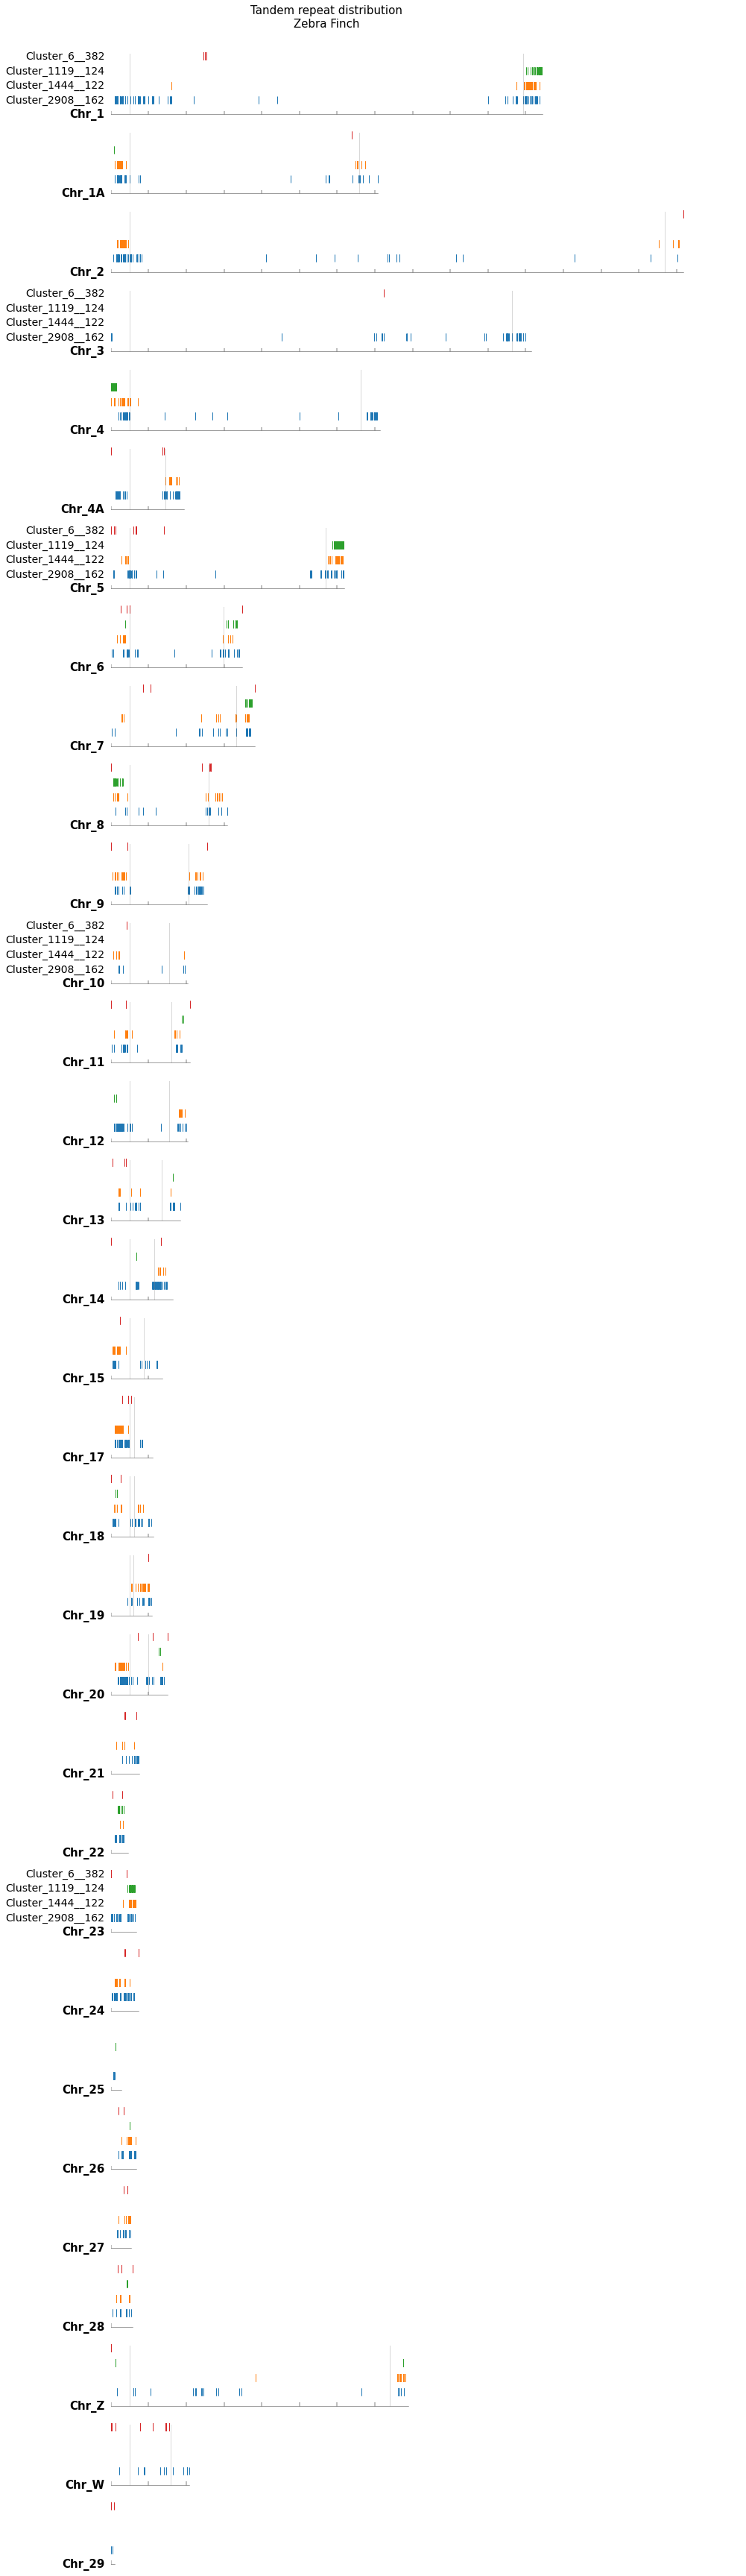

In [26]:
title = 'Tandem repeat distribution\nZebra Finch'
    
list_chromosomes = CNTR_chrs.Chr.tolist()
Larges_chr_size = CNTR_chrs.Size.max()
Largest_chr_len = float(Larges_chr_size)*1.1


max_y_value, max_axis = 1,1
min_axis = 0

counter = 0
fig, axs = plt.subplots(len(list_chromosomes), figsize=(14,1.5*len(list_chromosomes)))

monomers = Blast_test.ID.unique()
monomers =  ['Cluster_2908__162' ,'Cluster_1444__122','Cluster_1119__124','Cluster_6__382' ] 
    # Other redundant clusters: 'Cluster_2343__126','Cluster_2252__128', 'Cluster_690__108',
    #'Cluster_770__122', 'Cluster_2__380' is a version of 6


for Chr_ in list_chromosomes:
    To_plot = Tandem_blast[(Tandem_blast.Chr==Chr_)]
    
    Chr_size_ = list(CNTR_chrs[CNTR_chrs.Chr==Chr_].Size)[0]
    CTR_pos = CNTR_chrs[CNTR_chrs.Chr==Chr_].Center.to_list()[0] 
    delta_centromere = 0 #Larges_chr_size - CTR_pos
    CTR_pos_normalized =(CTR_pos+delta_centromere)/Largest_chr_len
    chr_size_normalized = (Chr_size_+delta_centromere)/Largest_chr_len
    
    axs[counter].set_xlim((0, 1))
    axs[counter].set_ylim((0, max_axis*1.1))
    axs[counter].text(-0.01, 0, Chr_, fontsize=15, ha='right', va='center', fontweight='bold')


    axs[counter].axhline(0,xmin=delta_centromere/Largest_chr_len, xmax=chr_size_normalized, color='gray')
    
    for tick_10Mb in range(0, Chr_size_, 10*Mb):
        normalized_tick = (tick_10Mb  +delta_centromere)/Largest_chr_len  
        axs[counter].axvline(normalized_tick, ymin=-.1, ymax= .05,  alpha=.5, color='gray', linewidth=2)
        
    ypos_inc = increment = (1/float(len(monomers)))
    for repeat_name in monomers :
        axs[counter].scatter(np.array((To_plot[To_plot.qseqid==repeat_name].midpoint + delta_centromere)/Largest_chr_len), len(To_plot[To_plot.qseqid==repeat_name].midpoint)*[ypos_inc], marker='|', alpha=1 , s=120, linewidth=1)
        if Chr_ in ['Chr_1','Chr2','Chr_3','Chr_5','Chr_10','Chr_23']:
            axs[counter].text(-0.01, ypos_inc, repeat_name, fontsize=14, ha='right', va='center')

        ypos_inc = increment + ypos_inc
        
    axs[counter].spines['top'].set_visible(False)
    axs[counter].spines['right'].set_visible(False)
    axs[counter].spines['bottom'].set_visible(False)
    axs[counter].spines['left'].set_visible(False)
    axs[counter].get_xaxis().set_ticks([])
    axs[counter].get_yaxis().set_ticks([])
    
    if Chr_size_ >10*Mb:
        first_5 = (5*Mb  +delta_centromere)/Largest_chr_len  
        axs[counter].axvline(first_5, ymin=0, ymax= .95,  alpha=.3, color='gray', linewidth=1)
        last_5 = (-5*Mb + Chr_size_ +delta_centromere)/Largest_chr_len   
        axs[counter].axvline(last_5, ymin=0, ymax= .95,  alpha=.3, color='gray', linewidth=1)

        
    if counter == 0:
        axs[counter].text(CTR_pos_normalized,(max_axis)*1.5,title, fontsize=15, horizontalalignment='center')
 

    counter=counter+1
    
#plt.legend(bbox_to_anchor=(.2,1), frameon=False)    
plt.tight_layout()
out_fig_name = ''.join(('ZebraFinch_Tandem_Monomers.pdf'))
print ("Saved as", out_fig_name)
plt.savefig(out_fig_name,bbox_inches='tight', transparent=True,)
plt.show()